## Parte 1 - Linear Regression

In [52]:
#notebook settings
%matplotlib inline

#import some useful libraries and utilities
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold

#setting some paths
path1='./cereales/'
path2='./credit/'

#parameters to try
params1 = np.array([0.2e-3, 0.4e-3, 0.6e-3, 0.8e-3, 1.0e-3])
params2 = np.linspace(4.0e-7,4.5e-7,5)

In [39]:
#Helper functions

"""
Function to generate histogram of winners (alphas)
"""
def make_hist(winners,parms):
    winners = np.array(winners)
    freqs = np.zeros(5)
    for i in xrange(5):
        freqs[i] = np.sum(parms[i]==winners)

    labels = ['alp1', 'alp2', 'alp3', 'alp4', 'alp5']
    pos = np.arange(len(labels))
    width = 1.0 
    ax = plt.axes()
    ax.set_xticks(pos + (width / 2))
    ax.set_xticklabels(labels)
    plt.bar(pos, freqs, width, color='r')
    plt.title('Best alpha for each dataset')
    plt.show()

def solve_all(algorithm, params=None, data_func=None):
    if params is not None:
        #list with winners-alphas
        winners = list()

    for i in xrange(20):
        #Loading dataset
        tr_file = path1+'cereales-tr-{0}.npy'.format(i)
        ts_file = path1+'cereales-ts-{0}.npy'.format(i)
        tr_data = np.load(tr_file)
        ts_data = np.load(ts_file)
        
        if data_func is not None:
            X_tr = data_func(tr_data[:,:-1])
        else: 
            X_tr = tr_data[:,:-1]
        y_tr = np.ascontiguousarray(tr_data[:,-1])
        #Adding column of 1's
        m,n = X_tr.shape
        X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)

        if data_func is not None:
            X_ts = data_func(ts_data[:,:-1])
        else: 
            X_ts = ts_data[:,:-1]
        y_ts = np.ascontiguousarray(ts_data[:,-1])
        #Adding column of 1's
        m,n = X_ts.shape
        X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)

        if params is not None:
            alpha,tr_cost,ts_cost = cross_alpha(X_tr, y_tr, algorithm, params)
            winners.append(alpha)
            beta,it = algorithm(X_tr, y_tr, alpha)
        else:
            beta,it = algorithm(X_tr, y_tr)
        print "###########################################################"
        print "Dataset: {0}".format(i)
        if params is not None:
            print 'Best alpha: {0}'.format(alpha)
            fig = plt.figure()
            fig.set_figheight(7)
            fig.set_figwidth(13)
            fig.add_subplot(121)
            plt.boxplot(tr_cost, showmeans=True, meanline=True)
            fig.add_subplot(122)
            plt.boxplot(ts_cost, showmeans=True, meanline=True)
            plt.show()
        print 'Training error: {0}'.format(mse(X_tr,y_tr,beta))
        print 'Testing error: {0}'.format(mse(X_ts,y_ts,beta))
        print 'N° iterations: {0}'.format(it)
        print 'Beta: {0}'.format(beta)
        print "###########################################################"
        print '\n'
    
    if params is not None:
        make_hist(winners,params)

In [ ]:
#Overall cost function for linear regresion
def J(X, y, beta):
    h = np.dot(X,beta)
    diff = h-y
    return 0.5*np.dot(diff,diff)

#Mean Squared Error 
def mse(X, y, beta):
    M,N = X.shape
    h = np.dot(X,beta)
    diff = h-y
    return (1./(M-1))*np.dot(diff,diff)

#Batch gradient descent for linear regression
def gd_batch(X, y, alpha, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    J1 = J(X,y,beta) #loss at previous iteration
    for i in xrange(max_iter):
        J0 = J1
        h = np.dot(X,beta)
        dJ = np.dot(X.T,h-y)
        beta -= alpha*dJ
        J1 = J(X,y,beta)
        if np.abs(J1-J0)/J0 < eps:
            break
    return (beta,i+1)

#Online gradient descent for linear regression
"""
Implmentation can be seen on gd.pyx. It was
made with Cython for seepdup
"""
#from gd import gd_online
def gd_online(X, y, alpha, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    J1 = J(X,y,beta) #loss at previous iteration
    for i in xrange(max_iter):
        J0 = J1
        for m in xrange(M):
            beta -= alpha*(np.dot(X[m],beta)-y[m])*X[m]
        J1 = J(X,y,beta)
        if np.abs(J1-J0)/J0 < eps: break
    return (beta,i+1)

#Newton-Raphson method for linear regression
def nr_linear(X, y, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    J1 = J(X,y,beta) #loss at previous iteration 
    Hess = np.dot(X.T,X) #Hessian matrix
    for i in xrange(max_iter):
        J0 = J1
        h = np.dot(X,beta)
        dJ = np.dot(X.T,h-y)
        beta -= np.linalg.solve(Hess, dJ)
        J1 = J(X,y,beta)
        if np.abs(J1-J0)/J0 < eps: break
    return (beta,i+1)

#Compute weights for all samples in X matrix, respect to x0
def weight(X, x0, tau):
    Diff = X - x0
    Diff *= Diff
    return np.exp(-1*np.sum(Diff,axis=1)/(2.*tau))

#weighted cost function
def wJ(X, y, beta, w):
    h = np.dot(X,beta)
    diff = h-y
    diff **=2
    return 0.5*np.dot(w,diff)

#Find best beta for locally weighted linear regression, with test x0
def min_weighted(X, y, x0, tau):
    #vector with weights
    W = np.diag(weight(X,x0,tau))
    M = np.dot(X.T, np.dot(W, X))
    b = np.dot(X.T, np.dot(W, y))
    return np.linalg.solve(M,b)

def rescale(M, a=0., b=1.):
    """ Rescale features of M to [a,b] range """
    #max and min vectors
    maxv = np.max(M, axis=0)
    minv = np.min(M, axis=0)
    return (b-a)*M/(maxv-minv) + (a*maxv-b*minv)/(maxv-minv)

def normalize(M):
    #mean and standard deviation vectors
    meanv = np.mean(M, axis=0)
    stdv = np.std(M, axis=0)
    return (M-meanv)/stdv

In [41]:
""" Find the best learning parameter for algorithm, between 
parameters in params using k-fold cross validation """
def cross_alpha(X, y, algorithm, params):
    #creating kfold
    m,n = X.shape
    kf = KFold(m, n_folds=5)
    tr_cost = np.empty((5,5))
    ts_cost = np.empty((5,5))
    i = 0 #index of fold
    
    for tr_index,ts_index in kf:
        j = 0 #index of parameter
        for param in params:
            X_train, X_test = X[tr_index], X[ts_index]
            y_train, y_test = y[tr_index], y[ts_index]
            beta,_ = algorithm(X_train, y_train, alpha=param)
            tr_cost[i,j] = mse(X_train, y_train, beta)
            ts_cost[i,j] = mse(X_test, y_test, beta)
            j += 1
        i += 1
        
    #arrays with mean costs for each alpha
    tr_mean = np.mean(tr_cost, axis=0) 
    ts_mean = np.mean(ts_cost, axis=0)
    return params[np.argmin(ts_mean)], tr_cost, ts_cost

def cross_tau(X, y, params):
    #creating kfolds
    m,n = X.shape
    kf = KFold(m, n_folds=5)
    
    for tr_index,ts_index in kf:
        for tau in params:
            X_train, X_test = X[tr_index], X[ts_index]
            y_train, y_test = y[tr_index], y[ts_index]
            
    
    return

In [5]:
m,n = X.shape
x0 = np.random.random(n)
min_weighted(X,y,x0,0.5)

NameError: name 'X' is not defined

## 1.1)

### Gradient descent batch for raw data

###########################################################
Dataset: 0
Best alpha: 4.5e-07


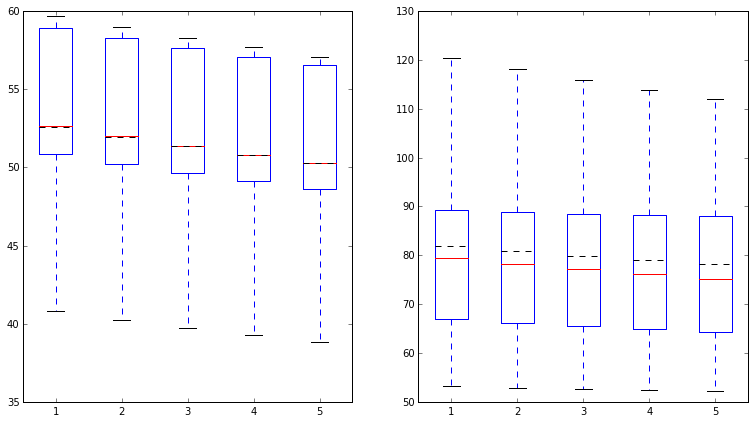

Training error: 47.7018651247
Testing error: 98.5365507026
N° iterations: 41839
Beta: [ 1.45007051 -0.07488509  3.6586664  -3.18223332 -0.06170004  3.49975134
  2.64216044  0.01071132 -0.01107893 -0.13169927  3.28244344  0.81753365
  1.61203648]
###########################################################


###########################################################
Dataset: 1
Best alpha: 4.5e-07


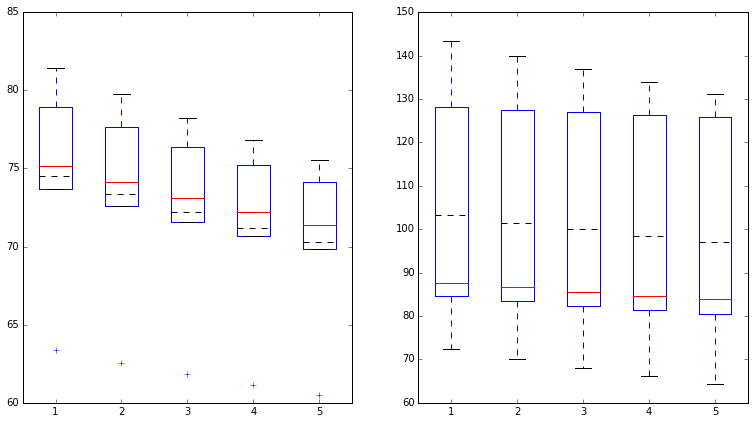

Training error: 64.7550597054
Testing error: 48.2315757796
N° iterations: 37395
Beta: [ 1.51151842 -0.13138068  3.85681757 -2.38975838 -0.0335923   2.53120612
  2.56108045  0.09368966  0.02998656 -0.12676098  2.72679839  0.78423382
  1.58448175]
###########################################################


###########################################################
Dataset: 2
Best alpha: 4.5e-07


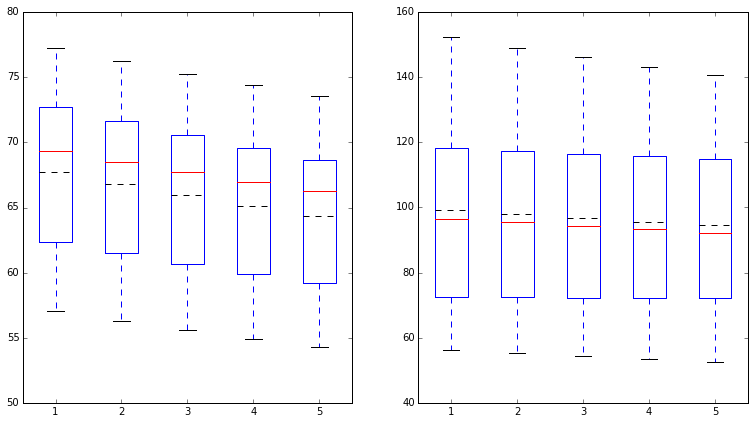

Training error: 60.7481463585
Testing error: 79.3615414274
N° iterations: 35558
Beta: [ 1.17969386 -0.13953799  3.78294308 -1.82756036 -0.03305847  2.50888648
  2.71785523  0.15927905  0.02106107 -0.13489473  2.33540385  0.68729504
  1.32478924]
###########################################################


###########################################################
Dataset: 3
Best alpha: 4.5e-07


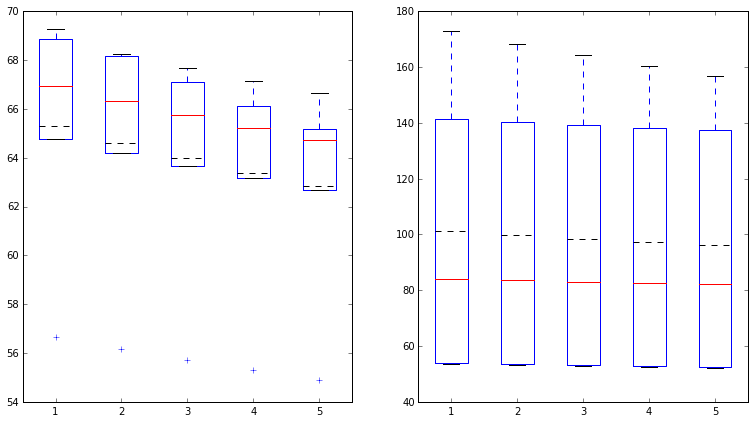

Training error: 58.9987667645
Testing error: 97.6149558458
N° iterations: 33429
Beta: [  1.25203426e+00   1.18167168e-03   3.01875186e+00  -2.88371921e+00
  -4.48843106e-02   3.51345829e+00   2.53504404e+00  -3.29583267e-01
  -5.33724219e-03  -1.66931668e-01   1.87341387e+00   5.78813824e-01
   1.45941431e+00]
###########################################################


###########################################################
Dataset: 4
Best alpha: 4.5e-07


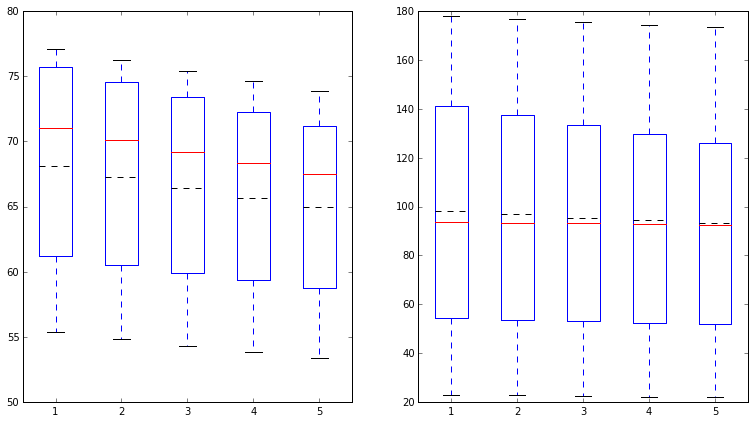

Training error: 60.3072912204
Testing error: 88.023192366
N° iterations: 33899
Beta: [ 1.24215199 -0.08193527  2.65716575 -2.15854073 -0.03925225  2.98855187
  2.71064704 -0.17171491  0.02214669 -0.15063159  2.70621456  0.82794457
  1.22588399]
###########################################################


###########################################################
Dataset: 5
Best alpha: 4.5e-07


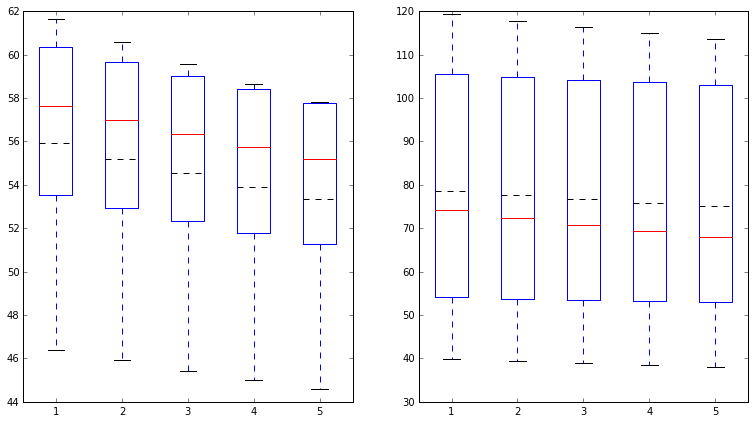

Training error: 50.8161360455
Testing error: 103.273046989
N° iterations: 37135
Beta: [ 1.20350502 -0.08930296  3.83324385 -2.45694911 -0.04535681  3.12053542
  2.55565498  0.00401994  0.02434499 -0.11672738  1.94519309  0.7931489
  1.26388671]
###########################################################


###########################################################
Dataset: 6
Best alpha: 4.5e-07


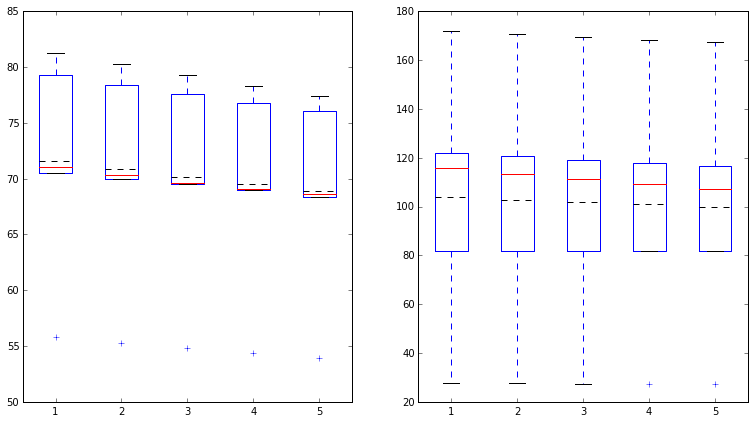

Training error: 65.6541052631
Testing error: 57.5892393027
N° iterations: 32693
Beta: [ 1.27903009 -0.03878925  3.40772812 -2.59294373 -0.02933009  3.04353951
  2.32056313 -0.29475475  0.01473876 -0.1526923   2.22168778  0.69725781
  1.34790144]
###########################################################


###########################################################
Dataset: 7
Best alpha: 4.5e-07


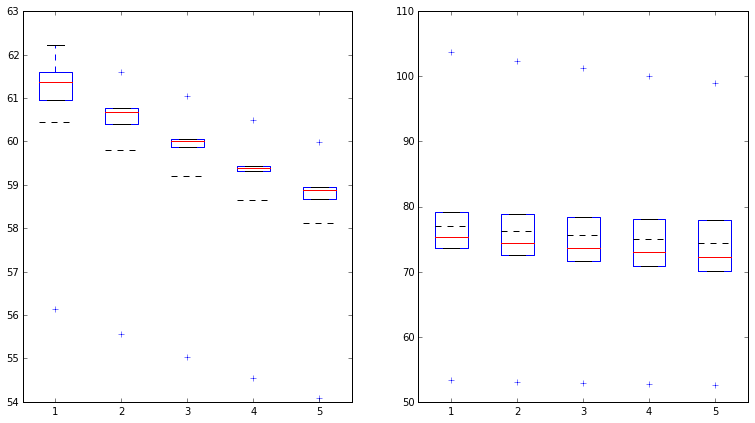

Training error: 55.4439862945
Testing error: 75.1149772436
N° iterations: 37075
Beta: [ 1.28365704 -0.08713122  3.98989369 -2.849145   -0.04344421  3.25455649
  2.5317626   0.11331768  0.01441116 -0.14838931  2.26488177  0.76079017
  1.49081129]
###########################################################


###########################################################
Dataset: 8
Best alpha: 4.5e-07


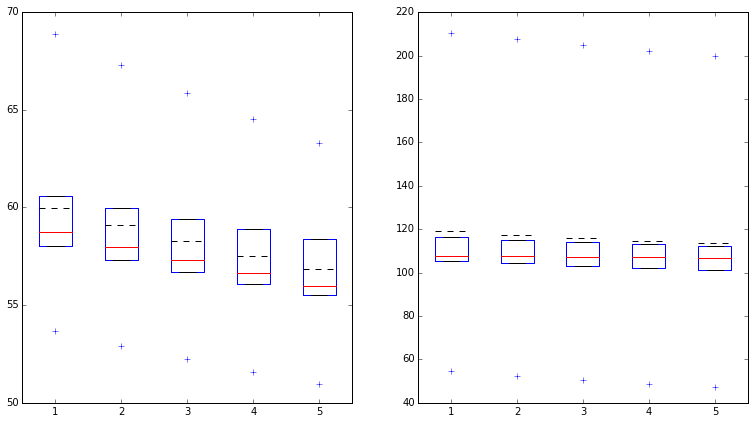

Training error: 54.5426469971
Testing error: 82.2107819498
N° iterations: 38927
Beta: [ 1.24561581 -0.07267351  3.2863172  -2.7469164  -0.05323766  3.01293599
  2.56609359  0.01704858  0.00336593 -0.12409025  3.19095961  0.80653327
  1.57989221]
###########################################################


###########################################################
Dataset: 9
Best alpha: 4.5e-07


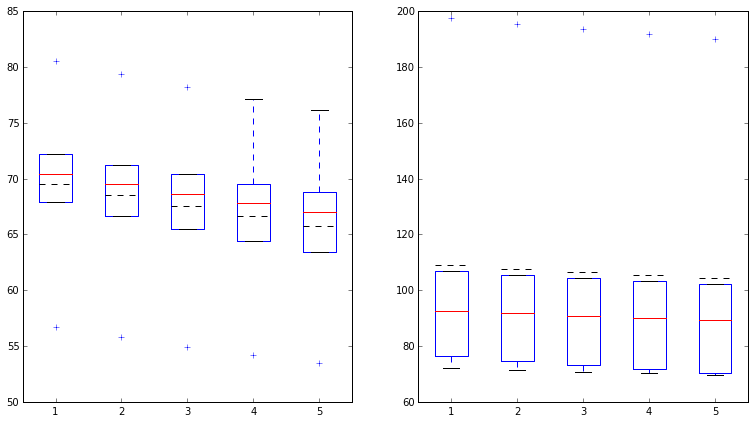

Training error: 62.4168368555
Testing error: 59.7595593067
N° iterations: 38408
Beta: [ 1.46658372 -0.10295414  4.0573884  -2.39316905 -0.03957536  2.27005469
  2.57954306  0.07813148  0.01603134 -0.14981853  2.72721511  0.84118777
  1.52602249]
###########################################################


###########################################################
Dataset: 10
Best alpha: 4.5e-07


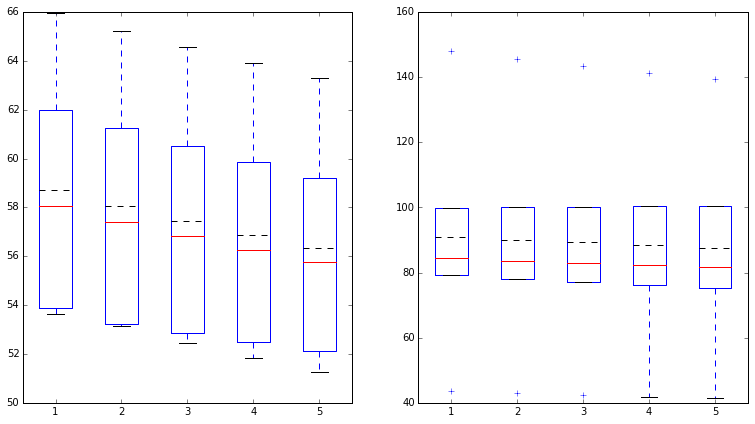

Training error: 54.2623055884
Testing error: 102.249628704
N° iterations: 35617
Beta: [ 1.16831853 -0.03918495  3.95638478 -2.63365326 -0.03014391  3.1621868
  2.18584239 -0.23403557  0.0088874  -0.08218795  1.50697396  0.74049203
  1.24216083]
###########################################################


###########################################################
Dataset: 11
Best alpha: 4.5e-07


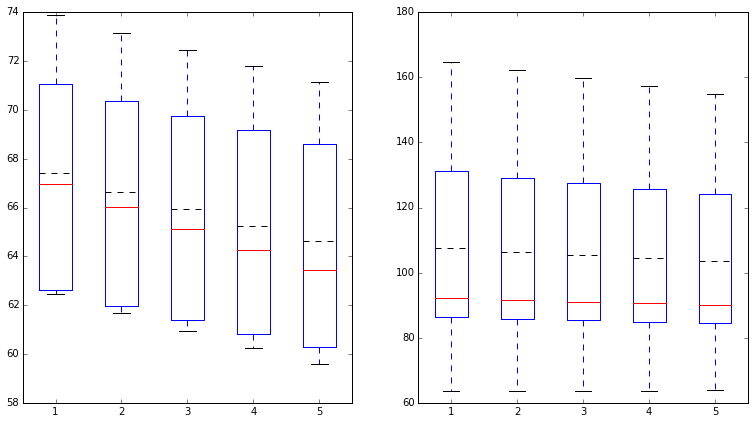

Training error: 62.0340545439
Testing error: 96.3581158257
N° iterations: 33306
Beta: [  1.10981655e+00  -5.10322177e-02   3.68956947e+00  -2.54729391e+00
  -4.67862581e-02   2.44906226e+00   2.47406756e+00   6.42013850e-02
   3.49242822e-03  -1.31328279e-01   1.88320918e+00   6.60243480e-01
   1.33877255e+00]
###########################################################


###########################################################
Dataset: 12
Best alpha: 4.5e-07


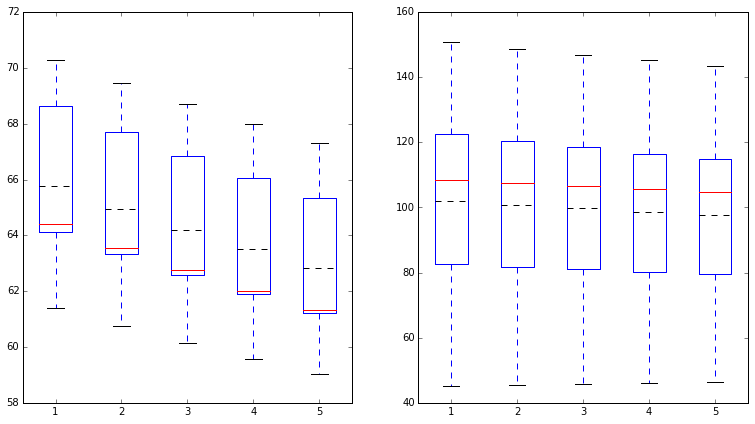

Training error: 60.1712404807
Testing error: 47.6982336899
N° iterations: 38458
Beta: [ 1.45433377 -0.08968786  4.24651413 -2.78368867 -0.03857028  2.92994807
  2.32117945  0.05748663  0.00854696 -0.10316297  2.88769513  0.78093322
  1.71517034]
###########################################################


###########################################################
Dataset: 13
Best alpha: 4.5e-07


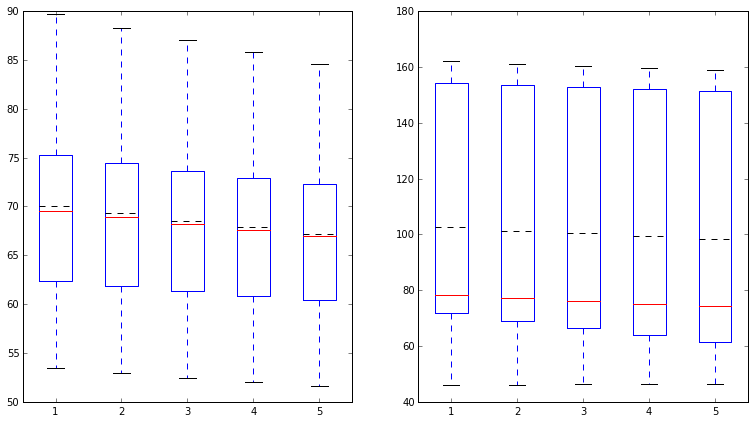

Training error: 63.8754224266
Testing error: 54.6855768246
N° iterations: 34544
Beta: [ 1.26294288 -0.06921313  3.7100431  -2.74170632 -0.04703039  2.85815788
  2.49956608 -0.02140664  0.01689035 -0.12755801  2.14607095  0.68777065
  1.60864618]
###########################################################


###########################################################
Dataset: 14
Best alpha: 4.5e-07


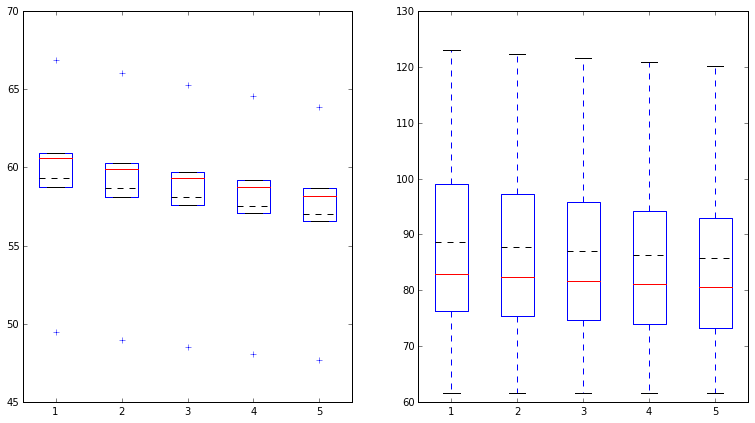

Training error: 55.3889121746
Testing error: 87.9559175097
N° iterations: 36435
Beta: [ 1.25097182 -0.06527964  4.28808828 -2.78390695 -0.03263313  2.25244654
  2.20500163  0.03132868  0.02280227 -0.0866293   2.26144347  0.67313098
  1.52788902]
###########################################################


###########################################################
Dataset: 15
Best alpha: 4.5e-07


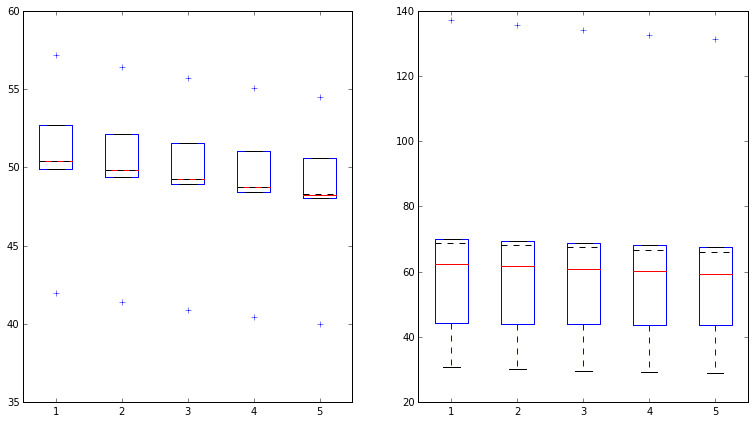

Training error: 46.1065815649
Testing error: 120.74160843
N° iterations: 41171
Beta: [ 1.43174894 -0.03773407  3.9914923  -2.78688194 -0.0362851   3.59588567
  2.08940944 -0.07587966 -0.00634996 -0.05640431  2.18350277  0.63561388
  1.13180144]
###########################################################


###########################################################
Dataset: 16
Best alpha: 4.5e-07


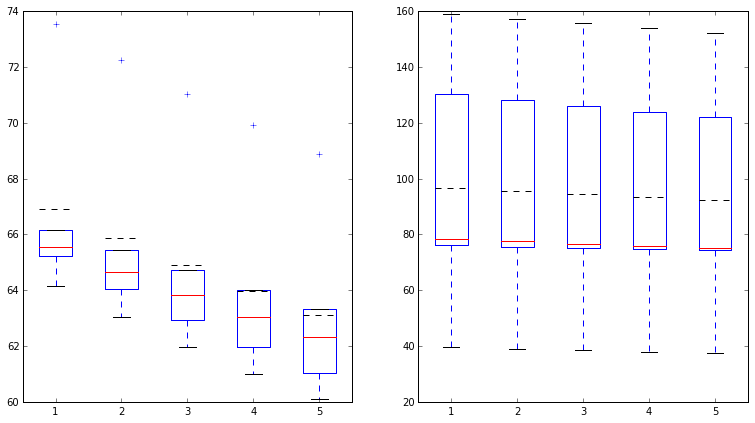

Training error: 58.7921426086
Testing error: 82.0169113703
N° iterations: 37313
Beta: [ 1.36353919 -0.14715022  3.46763084 -2.13118141 -0.0462796   2.57360503
  2.81836314  0.10845942  0.03626119 -0.10181231  2.47787117  0.62937244
  1.70474643]
###########################################################


###########################################################
Dataset: 17
Best alpha: 4.5e-07


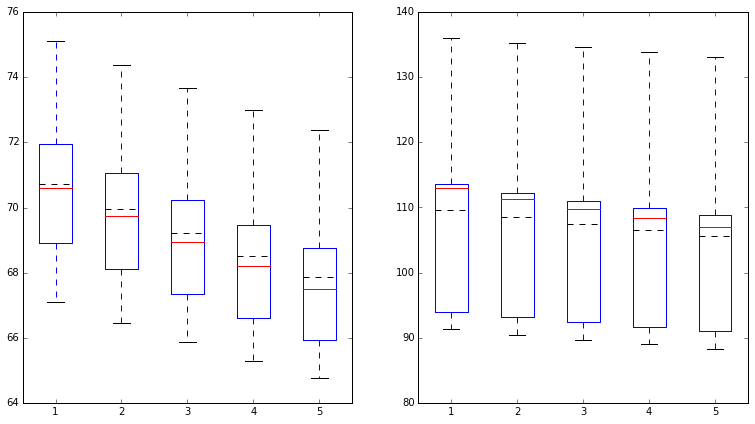

Training error: 65.6326333879
Testing error: 50.8059305089
N° iterations: 34370
Beta: [  1.43483394e+00   9.77333816e-03   3.23964259e+00  -3.05545702e+00
  -4.68517932e-02   3.28169124e+00   2.23782609e+00  -4.19906512e-01
   2.04841444e-03  -1.14762174e-01   2.38017662e+00   7.38252135e-01
   1.59065712e+00]
###########################################################


###########################################################
Dataset: 18
Best alpha: 4.5e-07


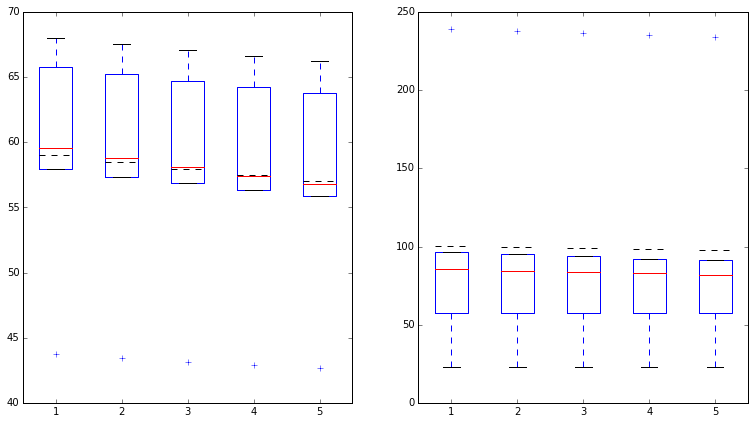

Training error: 56.5555399322
Testing error: 89.5246242367
N° iterations: 33340
Beta: [ 1.17370353 -0.07767876  3.53369067 -2.60439235 -0.03771718  3.58343137
  2.47778959  0.24231999 -0.00683109 -0.11976592  1.90929452  0.64435988
  1.29348523]
###########################################################


###########################################################
Dataset: 19
Best alpha: 4.5e-07


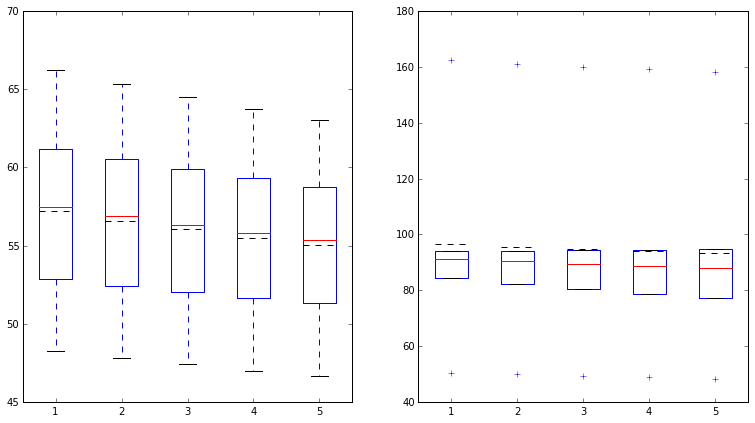

Training error: 53.8965499152
Testing error: 101.423157308
N° iterations: 36769
Beta: [ 1.27256142 -0.05788255  4.26424669 -2.18488152 -0.01905394  2.9310861
  2.01213426 -0.25756531  0.00593722 -0.10241576  2.55634214  0.77001516
  1.23669942]
###########################################################




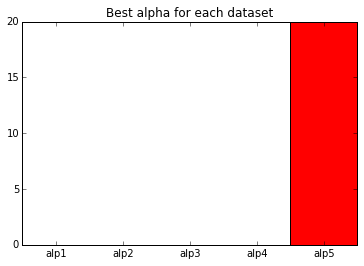

In [48]:
solve_all(gd_batch, params=params2)

### Gradient descent batch for rescaled data [0,1]

###########################################################
Dataset: 0
Best alpha: 0.0006


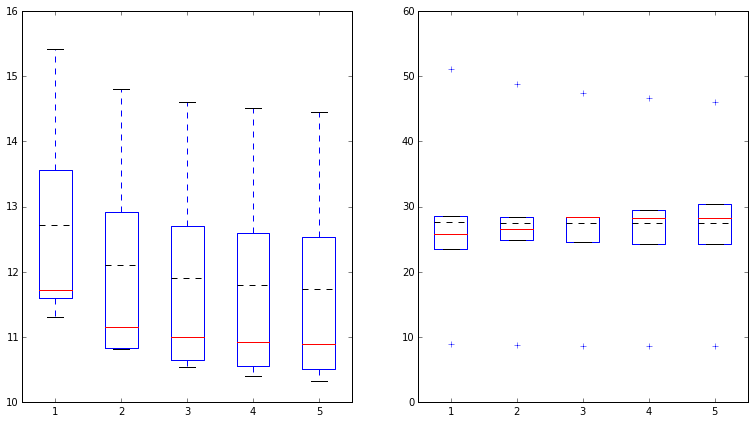

Training error: 13.0062050605
Testing error: 65.2571301369
N° iterations: 7718
Beta: [ 39.12819425 -21.12211183  18.39155828 -16.19472306 -15.69925885
  40.12054606  16.08049095 -16.64772494  -5.87286996 -13.08148087
   5.18930831   9.8497999   23.09701364]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.001


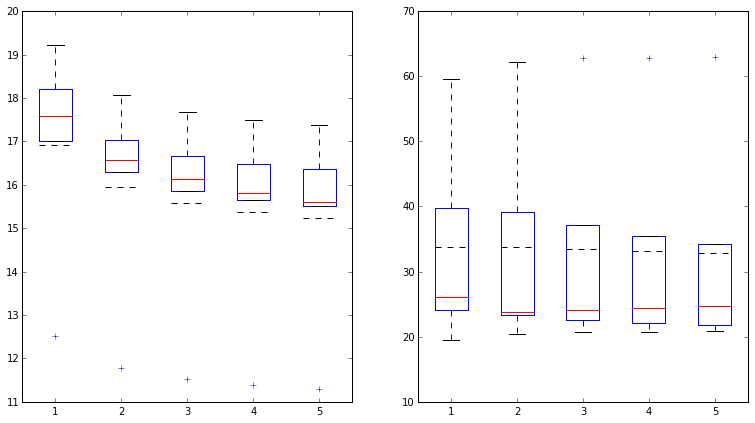

Training error: 16.3602257442
Testing error: 92.0230671423
N° iterations: 5765
Beta: [ 37.76010995 -23.91691135  19.33923593 -14.83153947 -11.34834923
  36.1198051   15.86964541 -12.49452803  -4.60486208 -10.83990299
   4.00286163   9.22876201  21.28151669]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.001


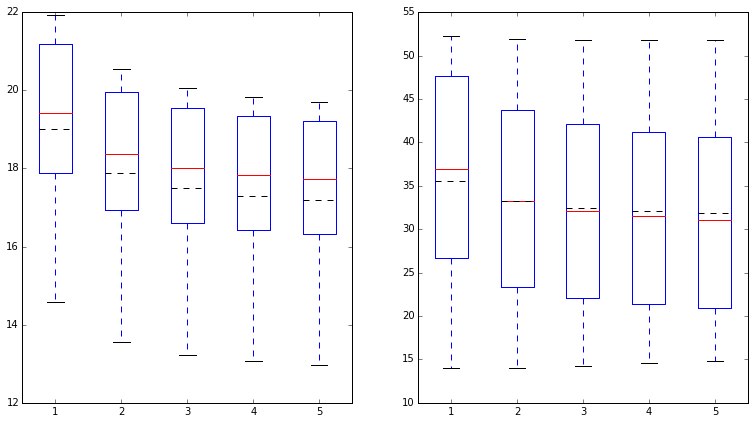

Training error: 18.1457842322
Testing error: 115.610985266
N° iterations: 5754
Beta: [ 40.97730612 -26.26603377  20.32655244 -15.10345033 -12.23326568
  40.2965877   15.18332197 -12.63207439  -9.01530236 -12.94318652
   6.49128172   8.50802687  20.73482906]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.001


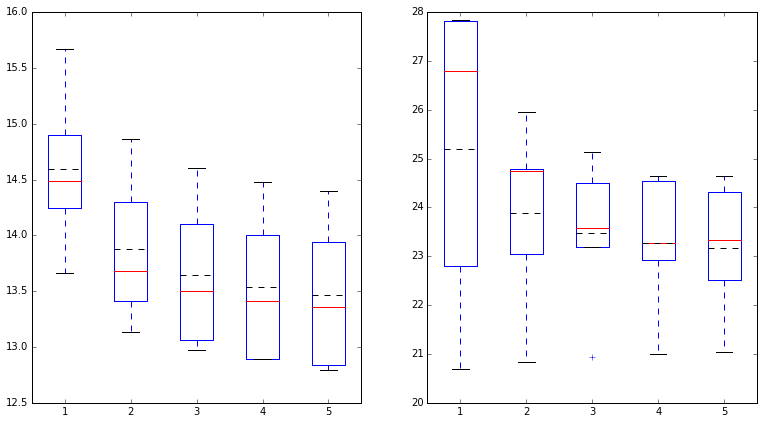

Training error: 14.1017329842
Testing error: 171.105766665
N° iterations: 5215
Beta: [ 43.47982853 -23.81054187  18.97143454 -14.94358074 -12.17779594
  40.78925657  14.30216321 -11.27322017  -6.88497476 -13.62507209
   4.77859147   5.18558864  17.3844609 ]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.001


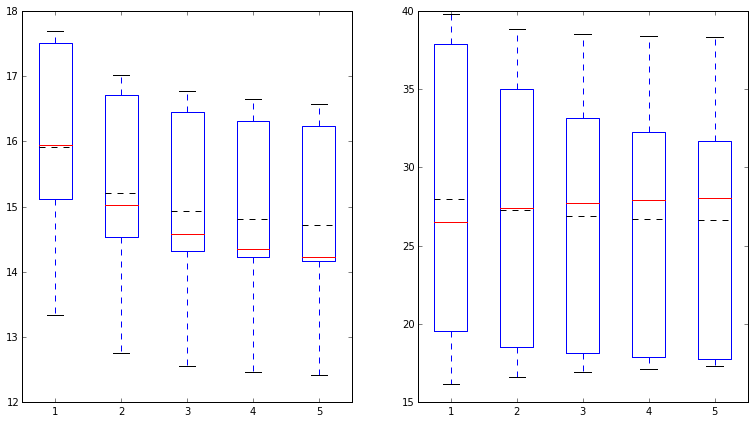

Training error: 15.5749130727
Testing error: 55.4477742699
N° iterations: 4782
Beta: [ 38.13862568 -22.8524058   19.41704046 -16.35695225 -14.1692096
  36.19605047  15.17684372 -14.74891235  -4.31813451 -13.3418267
   5.58138398  10.01687184  15.2289205 ]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.0002


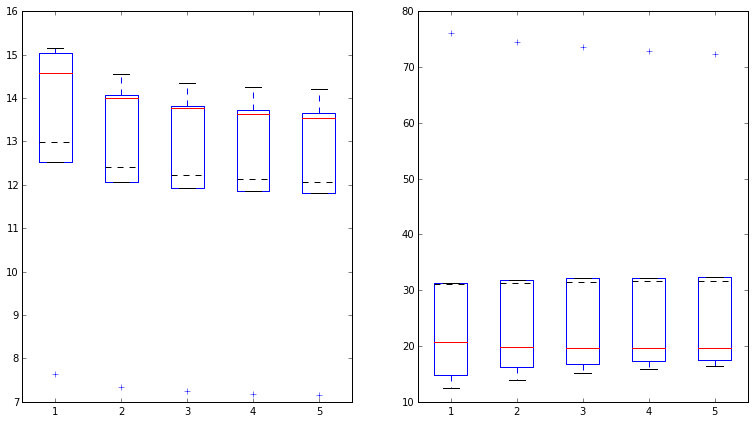

Training error: 14.2610314693
Testing error: 53.7595016258
N° iterations: 13100
Beta: [ 38.96905971 -22.3496242   18.61817791 -14.99228895 -16.47448789
  33.294526    18.74986081 -15.87213961   2.06616709 -11.27229725
   2.95665756   8.07107353  19.50895907]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.0002


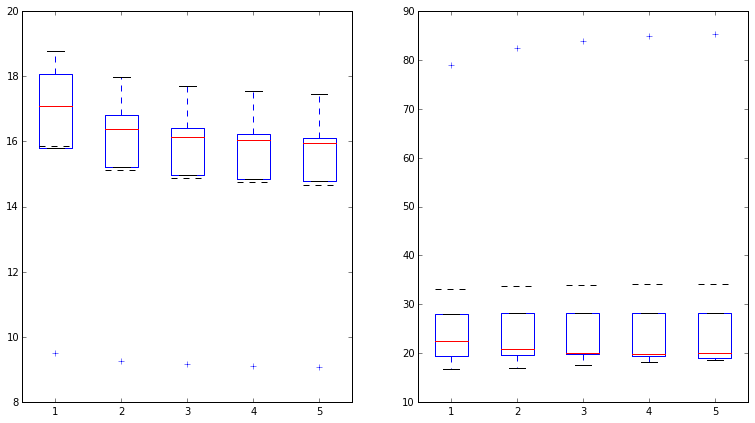

Training error: 17.0409159049
Testing error: 138.507544424
N° iterations: 11305
Beta: [ 41.70983088 -20.51953562  16.39039783 -14.08088911 -14.51329912
  29.63989364  15.73925204 -15.08751566   2.57449713 -13.14783703
   4.97107636   4.81431761  19.61171992]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.001


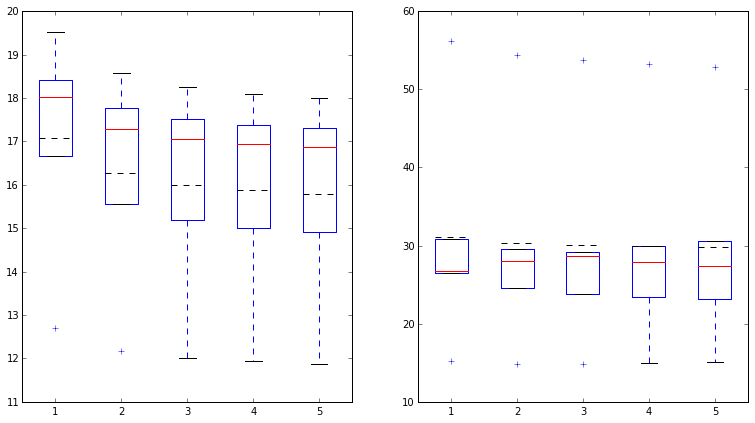

Training error: 16.7780811429
Testing error: 47.9171960704
N° iterations: 4865
Beta: [ 35.24725339 -23.12432222  19.24090643 -16.67993252 -15.71289131
  39.08325148  17.43375422 -14.25227046  -4.91821459 -13.17778673
   5.36529844  11.07718709  21.70014071]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.0004


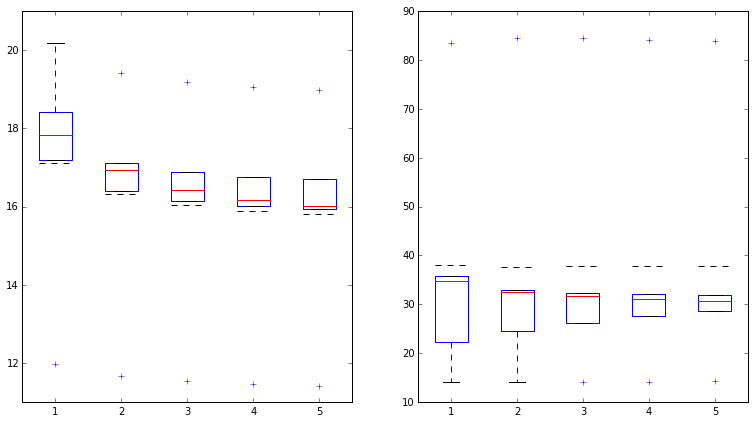

Training error: 17.6594834655
Testing error: 27.7334819973
N° iterations: 8714
Beta: [ 37.42648789 -21.9440614   17.92223893 -15.09850571 -13.9567529
  34.57936934  10.66467718 -17.44238188  -2.3707696  -12.39076294
   4.7661502   11.76878448  24.4317579 ]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.0006


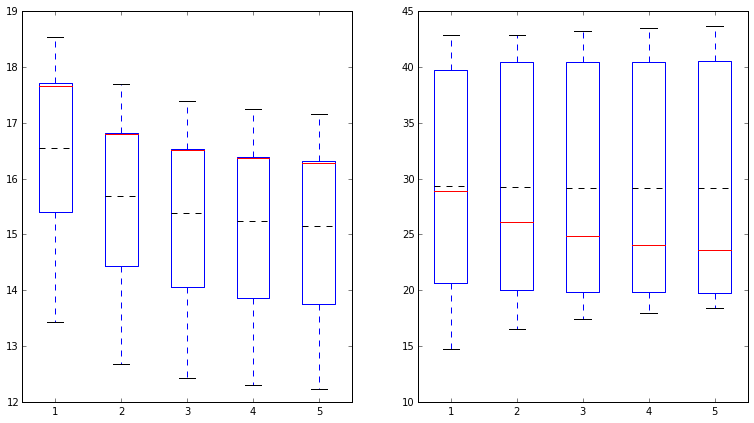

Training error: 16.3081104286
Testing error: 337.991435488
N° iterations: 7331
Beta: [ 36.07809829 -23.34706011  21.82703513 -16.90253197 -14.50602867
  30.50461255  15.59067892 -14.39360658 -10.69501581 -14.76462896
   5.72860295  12.19735217  20.68295466]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.001


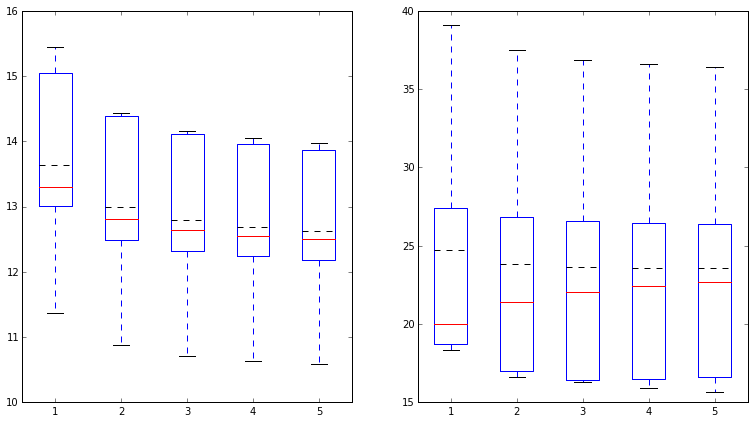

Training error: 13.4248859313
Testing error: 76.0132818686
N° iterations: 4895
Beta: [ 42.5434952  -21.13316114  21.98088829 -15.69155676 -15.44222201
  35.89580294  16.58903568 -13.43732599  -4.50854314 -10.56698216
   3.68367618   3.3306186   18.37652304]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.0002


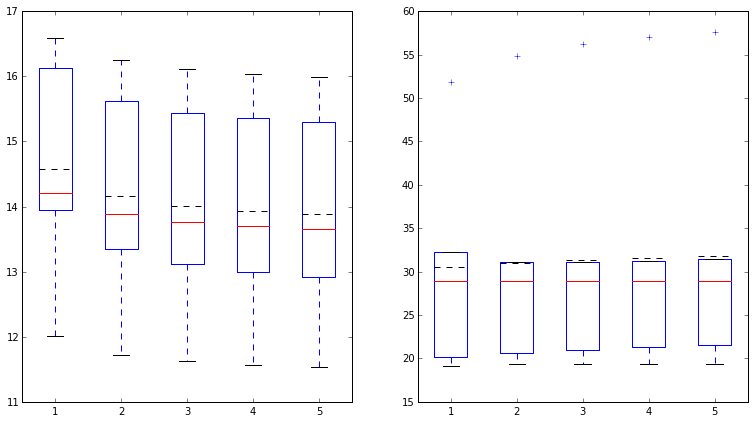

Training error: 15.8168112322
Testing error: 29.6423010367
N° iterations: 9607
Beta: [ 42.78315122 -21.42344317  18.90715836 -20.04294434 -13.2358552
  20.77143974  11.83444716 -15.35479563   0.08628419 -13.37862242
   4.28844871   9.81112513  19.07971477]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.0004


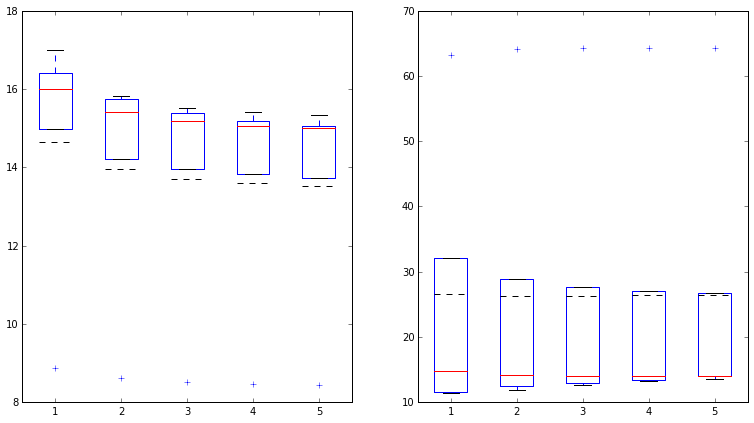

Training error: 14.7897334494
Testing error: 79.6061371602
N° iterations: 8756
Beta: [ 40.66170122 -23.03617014  17.83509579 -17.49820924 -14.65334601
  31.24612974  12.5497103  -17.15826607  -0.68050394  -8.31055737
   3.77579986  12.55725252  19.39283189]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.001


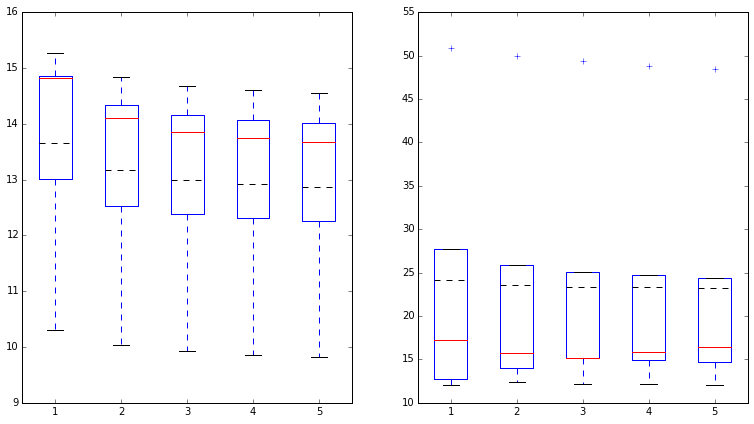

Training error: 13.5218597059
Testing error: 246.084167693
N° iterations: 4208
Beta: [ 39.03918344 -25.42444857  15.04479934 -14.00107694 -14.79234579
  28.6564351   13.8848172  -19.19484891  -5.21978877 -12.58570322
   5.25564017  13.45444692  25.19615693]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.0004


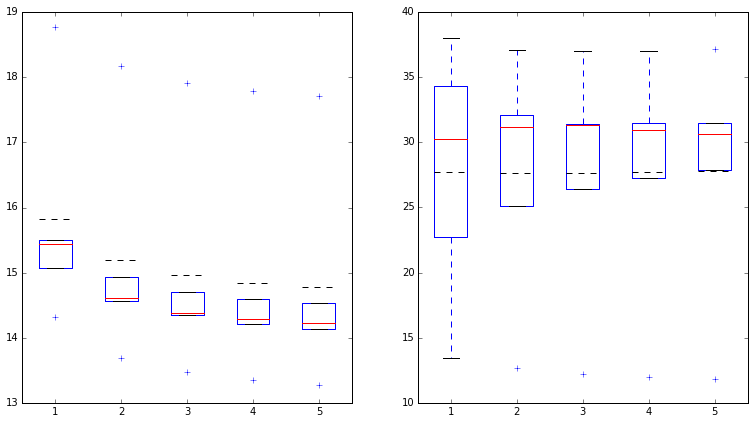

Training error: 16.0666898014
Testing error: 117.196223122
N° iterations: 7069
Beta: [ 34.73242323 -22.10504461  19.13642107 -17.57468323 -12.91483417
  24.70000691  16.79789533 -12.87150976  -0.28195429  -9.29053417
   4.82209831   7.73622924  21.85011054]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.001


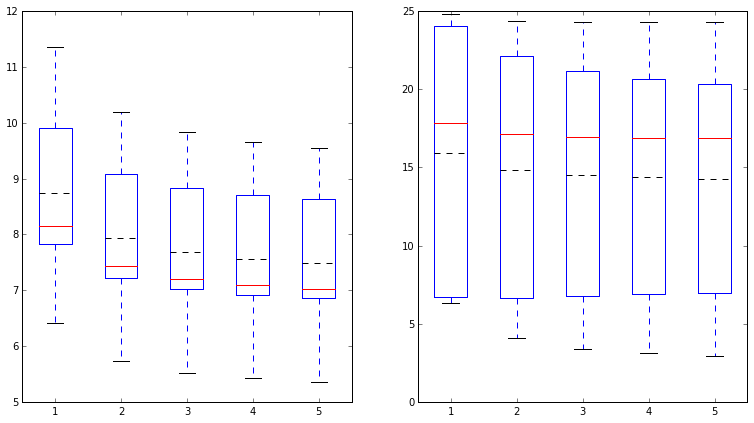

Training error: 7.96105164535
Testing error: 102.779537282
N° iterations: 8665
Beta: [ 49.03295931 -13.977522    17.61870346 -18.44610692 -13.4755449
  43.5616765   11.10390151 -19.2063919  -10.86015377  -6.45306249
   2.4884307    3.70092436   4.68954867]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.001


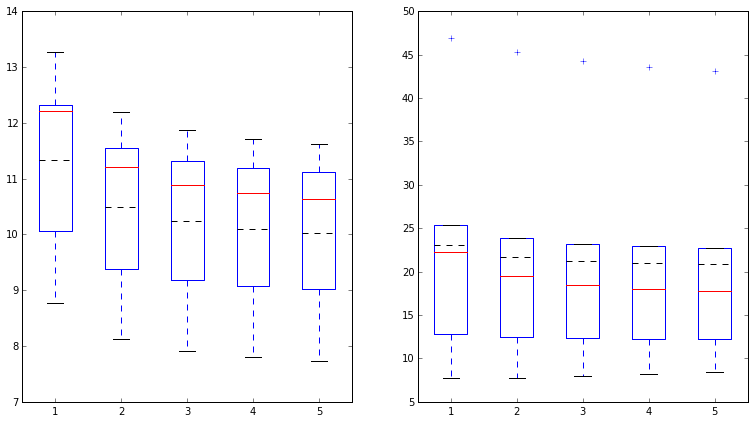

Training error: 10.6974314356
Testing error: 509.388015464
N° iterations: 7349
Beta: [ 38.46720962 -24.62821952  21.09077848 -16.50926549 -14.38527414
  42.70979748  16.51791103 -13.16249586 -10.81589923 -10.3028068
   3.98293763  11.99953081  19.99351146]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.001


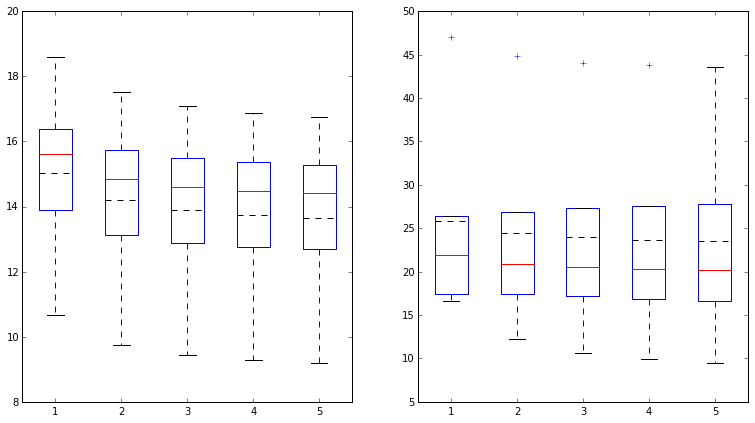

Training error: 14.3023622226
Testing error: 72.9172185356
N° iterations: 5337
Beta: [ 42.47136368 -22.96164866  19.89721547 -12.74344918 -13.39477061
  36.11799981  14.4465576  -13.38551719  -4.56301128 -13.5879567
   4.74349268   7.00580626  18.3825284 ]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.001


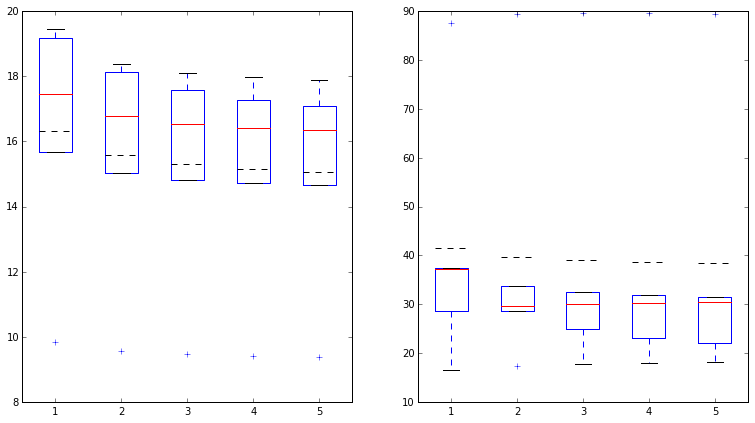

Training error: 16.4039458304
Testing error: 101.716074157
N° iterations: 4981
Beta: [ 41.6826372  -23.14865566  18.04465529 -16.13808303 -12.64264225
  39.99834988  14.96571734 -12.93775712  -6.2268374  -12.74674133
   5.67665948   6.40183894  18.60261297]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.0004


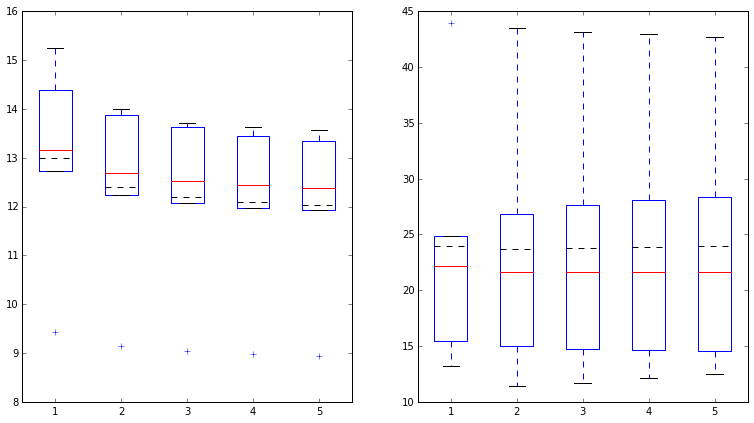

Training error: 13.1956721947
Testing error: 79.6597927613
N° iterations: 8863
Beta: [ 41.63488855 -20.52358041  17.59161829 -15.95919783 -13.44273995
  33.85212038  11.4521146  -16.65381385  -3.90272127  -9.81863875
   4.54018838  10.42277224  12.00998365]
###########################################################




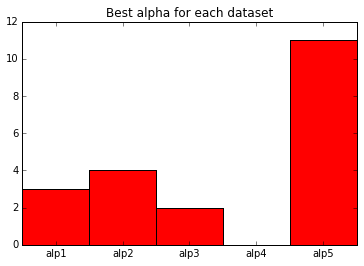

In [49]:
solve_all(gd_batch, params=params1, data_func=rescale)

### Gradient descent batch for normalized data

###########################################################
Dataset: 0
Best alpha: 0.0002


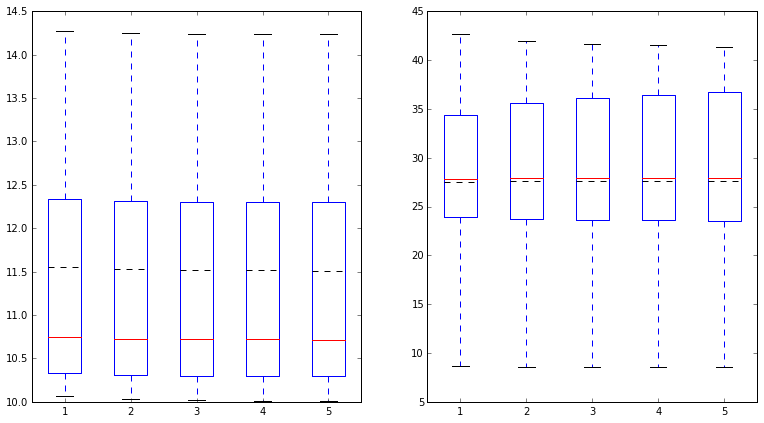

Training error: 12.7266740348
Testing error: 38.4079585793
N° iterations: 1535
Beta: [ 42.22724     -4.04315611   4.26533185  -3.44623502  -3.92100029
   7.94102272   3.2702556   -4.1383568   -1.97993514  -3.21326375
   2.34548981   1.78377407   3.69012969]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.0002


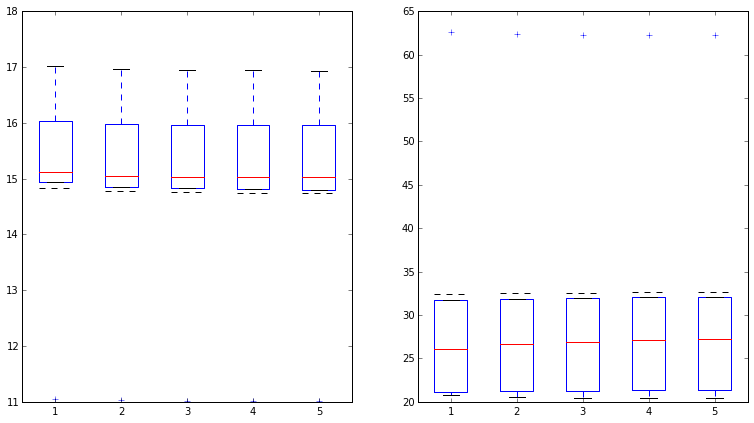

Training error: 16.0715344155
Testing error: 65.1941175822
N° iterations: 1897
Beta: [ 43.83778667  -4.66430519   4.32313969  -3.2124935   -3.14395908
   7.50054076   2.84675912  -3.45460573  -1.87703206  -2.3225976
   1.84182202   1.79539497   3.46750775]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.001


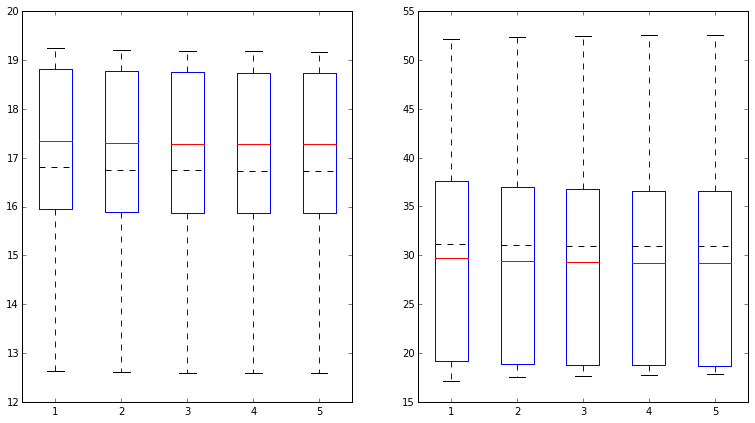

Training error: 17.7788520385
Testing error: 18.2024811924
N° iterations: 485
Beta: [ 42.41314667  -4.47172873   4.69814762  -3.18592618  -3.26956741
   8.32026521   3.10969724  -3.16872746  -3.04440902  -3.11591235
   2.99825766   1.69255389   3.66733914]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.0002


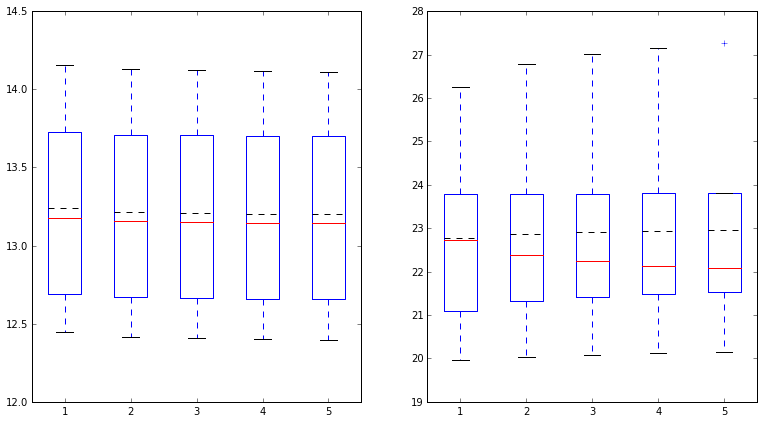

Training error: 13.9377761345
Testing error: 48.6525469488
N° iterations: 1203
Beta: [ 43.11717279  -4.47464154   4.35683157  -3.15153493  -3.3965321
   6.59515551   3.27512567  -2.92834692  -1.79515558  -3.28448074
   2.09995663   0.88652413   2.66022111]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.0002


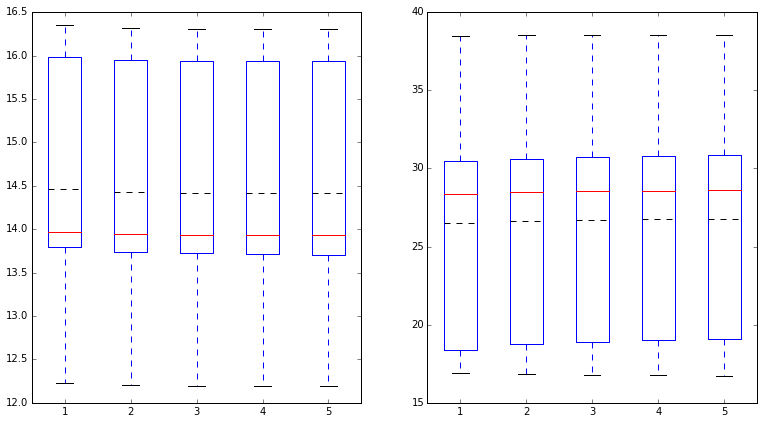

Training error: 15.3894271276
Testing error: 24.1581873664
N° iterations: 1429
Beta: [ 42.22333332  -4.4092344    4.34356126  -3.3012791   -3.46030416
   7.15808906   2.74896063  -3.54196747  -1.47858574  -2.95093284
   2.45283814   1.64211508   2.80813224]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.0002


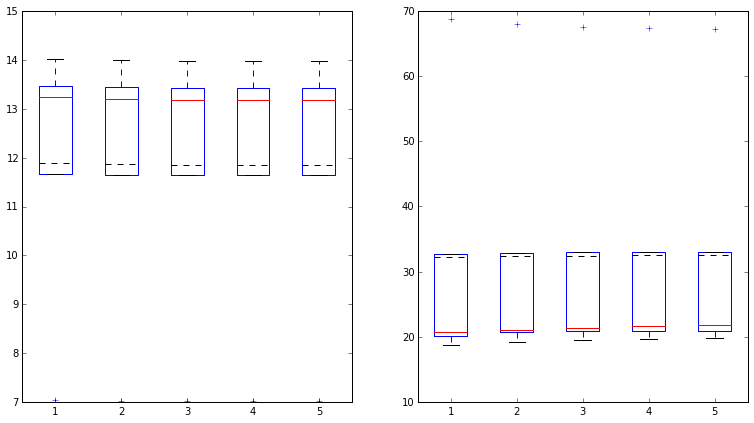

Training error: 13.3703648326
Testing error: 27.1554482493
N° iterations: 1263
Beta: [ 41.80137312  -4.39506149   4.17481775  -2.85725637  -3.94581553
   7.10316274   3.57486583  -3.68668924  -0.82935852  -2.64027829
   1.5479853    1.48896418   3.21502106]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.001


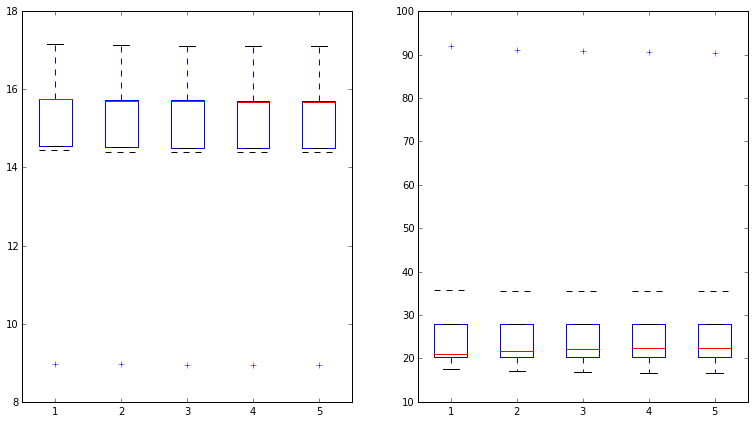

Training error: 15.7806050056
Testing error: 50.1360687667
N° iterations: 379
Beta: [ 43.19453333  -4.55099884   4.00533916  -2.42811103  -3.53478696
   7.34380252   3.02588211  -3.66421704  -1.40322796  -3.16490312
   2.47981801   1.3434567    3.36077348]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.0002


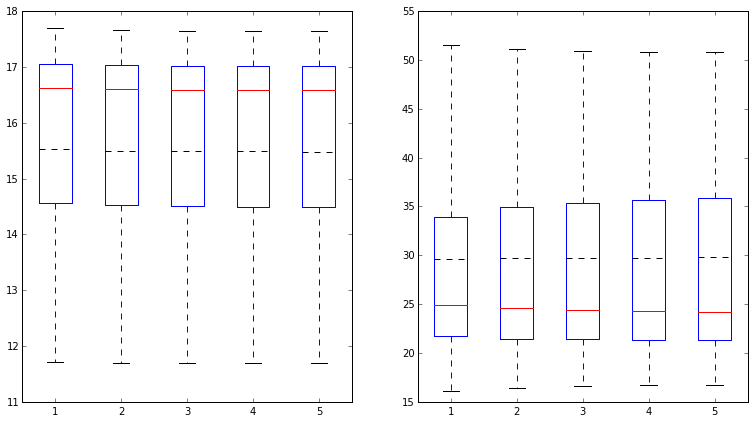

Training error: 16.5841191369
Testing error: 28.077556808
N° iterations: 1367
Beta: [ 42.58398662  -4.28888244   4.54616723  -3.62229033  -4.01611937
   7.51142511   3.00496778  -3.35166135  -1.57069433  -2.79528008
   2.41798063   1.99008375   3.72507089]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.0002


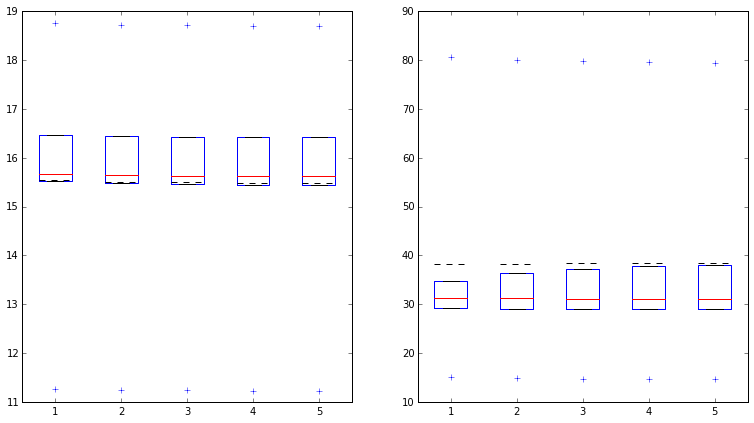

Training error: 17.0797580788
Testing error: 18.6923467845
N° iterations: 1403
Beta: [ 41.40637331  -4.00884774   4.08740679  -2.94931446  -3.52231715
   7.38863638   2.591044    -4.3828369   -1.56511933  -3.04335534
   2.17415141   2.33909849   4.04414028]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.0002


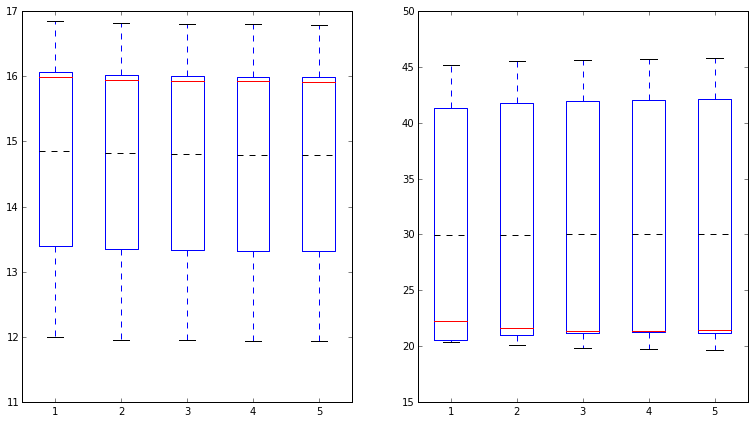

Training error: 15.8926108555
Testing error: 32.4322681958
N° iterations: 1875
Beta: [ 41.79716     -4.26922875   5.09343193  -3.58302301  -3.78270513
   7.61725877   2.90182797  -3.80030809  -3.26869871  -3.34650194
   2.63304474   2.40970524   3.71457711]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.0002


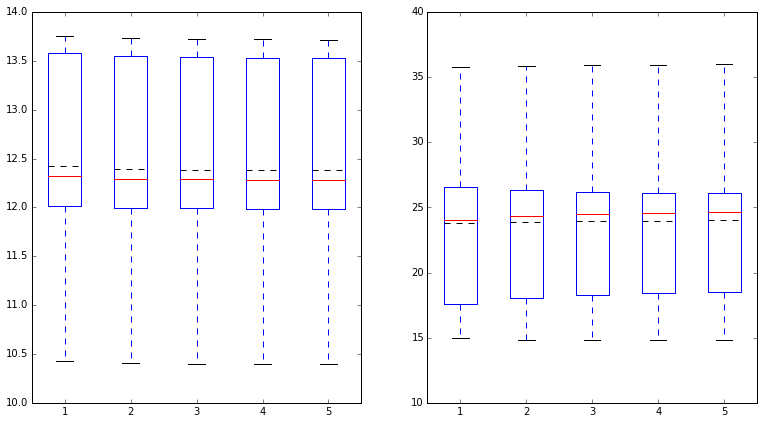

Training error: 13.2809364772
Testing error: 51.964392846
N° iterations: 1348
Beta: [ 43.12089327  -3.91445738   4.88977556  -2.88497312  -3.52008254
   7.00679403   2.98855587  -3.55531901  -1.36892297  -2.34585116
   1.60257793   0.7766664    2.97295963]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.0002


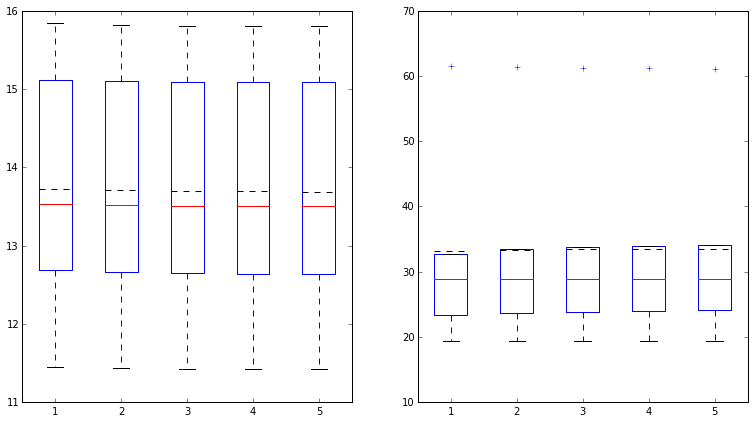

Training error: 15.1229661239
Testing error: 58.2778323768
N° iterations: 1094
Beta: [ 40.59829066  -4.13029944   4.12549039  -3.91258229  -3.35396442
   5.02685685   2.51194793  -3.88477033  -0.86672198  -2.98968259
   1.91552092   2.17620455   2.9309228 ]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.0002


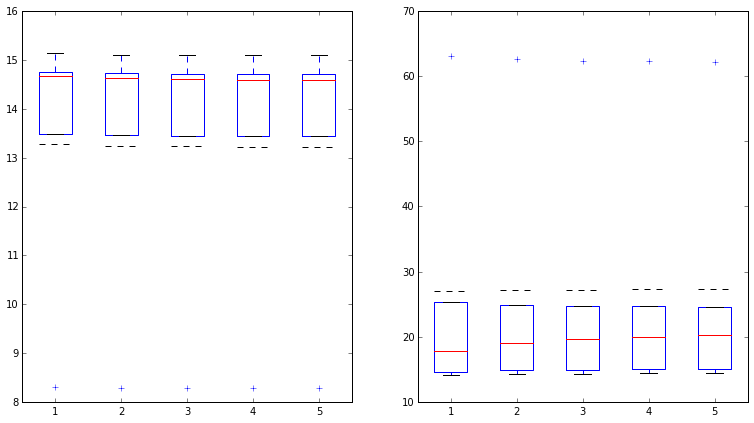

Training error: 14.2704574864
Testing error: 33.4736955049
N° iterations: 1489
Beta: [ 42.77134666  -4.19268165   3.73253299  -3.57369981  -3.68015717
   6.87015278   2.17608844  -4.37087821  -1.22942989  -1.91536645
   1.81116495   2.43808041   3.40614342]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.0006


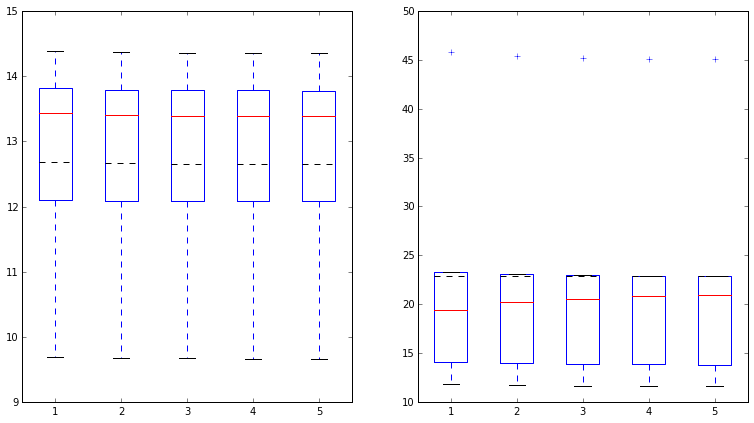

Training error: 13.3686890914
Testing error: 49.4021401471
N° iterations: 510
Beta: [ 42.50937333  -4.46086979   3.44498257  -2.5510803   -3.74231756
   6.72429409   2.24538682  -4.78063591  -1.48039531  -3.17631813
   2.31424334   2.41344332   4.31689767]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.0002


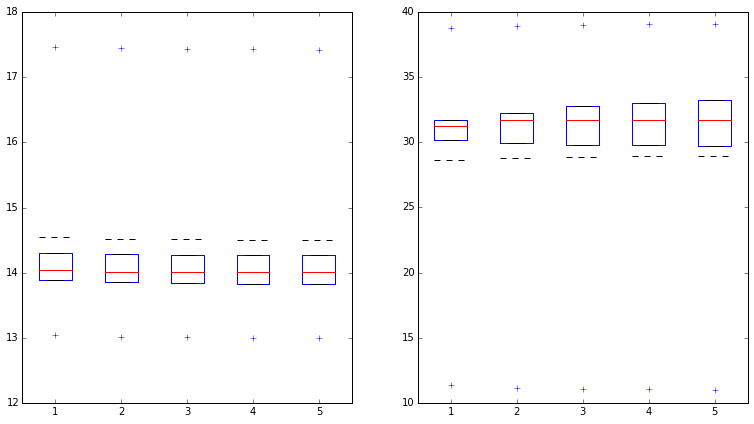

Training error: 15.5571989603
Testing error: 62.1502546032
N° iterations: 1247
Beta: [ 40.89617307  -4.41645044   4.65591513  -3.24699131  -3.01341205
   6.15241167   3.18925751  -3.01318514  -0.7306811   -1.94002047
   2.23849568   1.67650332   3.7519758 ]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.0002


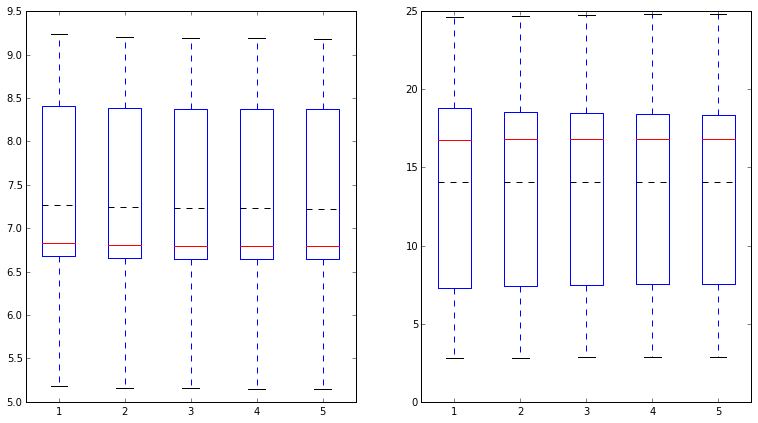

Training error: 7.7831599526
Testing error: 103.539701305
N° iterations: 2418
Beta: [ 42.47049333  -2.16743978   3.95379796  -3.6437795   -3.34902027
   8.32182208   1.72541111  -4.85992061  -3.09280853  -1.05674451
   1.0511798    0.68664537   0.87871878]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.001


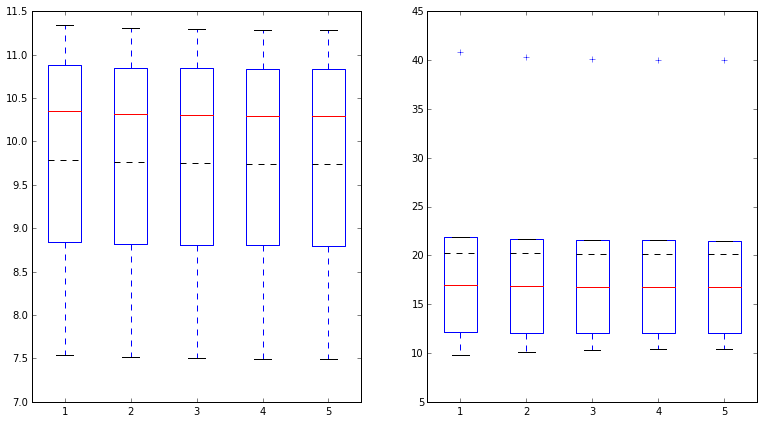

Training error: 10.4686233286
Testing error: 79.8182740031
N° iterations: 611
Beta: [ 43.07214667  -4.52936459   4.94480033  -2.9628303   -3.72101936
   9.0866287    2.57665021  -3.61498414  -3.47327674  -1.90466769
   1.7759778    2.30181467   3.36992567]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.0004


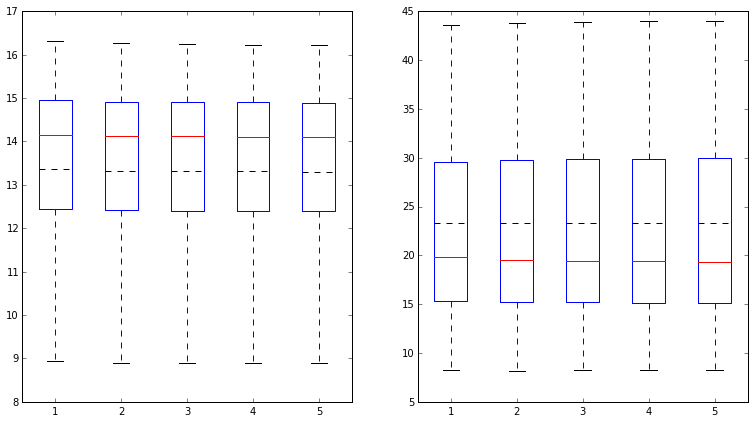

Training error: 14.0575024157
Testing error: 39.4462557317
N° iterations: 864
Beta: [ 42.70348     -4.73154876   4.6189854   -2.12763511  -3.33441176
   6.90125957   2.6170522   -3.50309675  -1.66047681  -2.91769669
   1.99469464   1.32792442   3.13403565]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.001


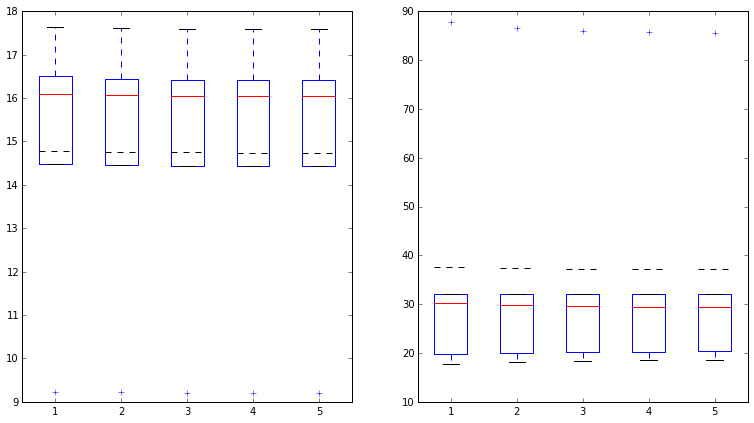

Training error: 16.1738495233
Testing error: 19.219045776
N° iterations: 323
Beta: [ 42.40008     -4.07718548   4.25235923  -3.49537098  -3.10156829
   7.34537652   3.23673607  -2.81520373  -1.91696785  -2.69105263
   2.50975743   0.92039433   3.09377533]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.001


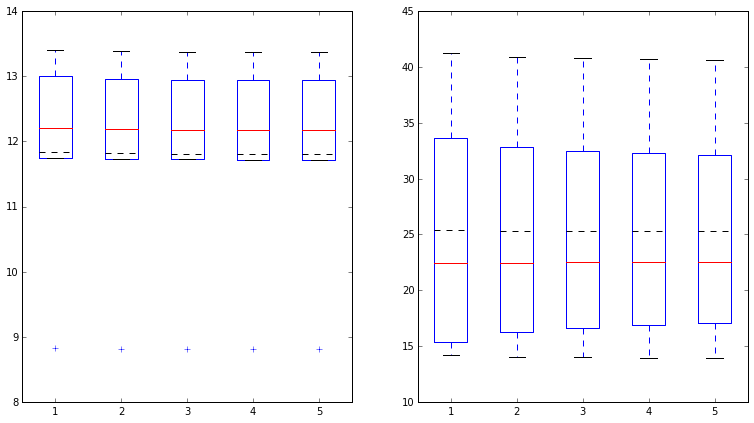

Training error: 12.7453067041
Testing error: 41.4905102572
N° iterations: 382
Beta: [ 42.15890667  -3.83045019   4.30209724  -2.74105279  -2.99493926
   7.40650418   2.00820488  -4.30750285  -2.0370021   -2.28008578
   2.14499976   2.04376586   2.64868626]
###########################################################




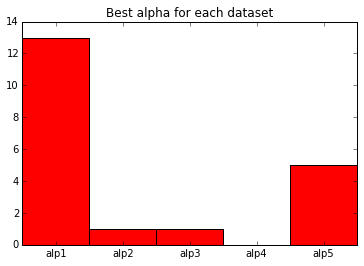

In [50]:
solve_all(gd_batch, params=params1, data_func=normalize)

### Gradient descent online for raw data

###########################################################
Dataset: 0
Best alpha: 4.5e-07


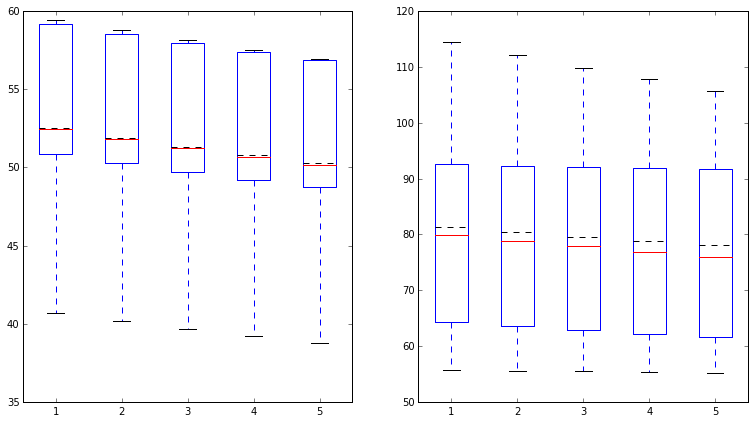

Training error: 47.893692584
Testing error: 92.0966603914
N° iterations: 41750
Beta: [ 1.44743538 -0.07561652  3.75762753 -3.18374354 -0.05915529  3.49252504
  2.63832438  0.01618509 -0.01063685 -0.13032407  3.33221125  0.82855592
  1.60927934]
###########################################################


###########################################################
Dataset: 1
Best alpha: 4.5e-07


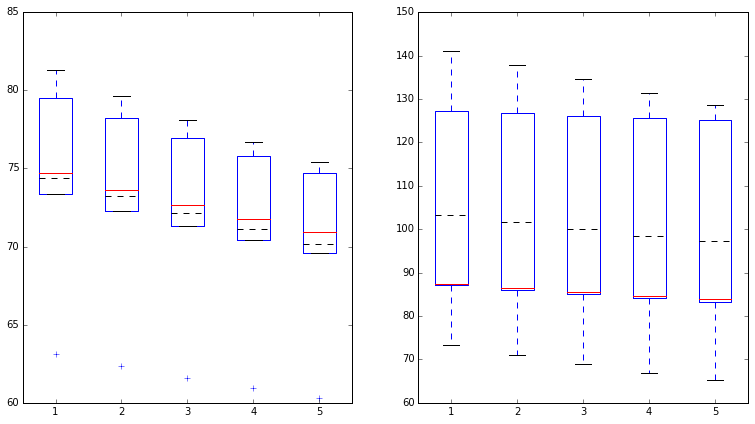

Training error: 64.6988609429
Testing error: 47.9123694862
N° iterations: 37329
Beta: [ 1.53626613 -0.13388669  3.82033968 -2.33312892 -0.03380505  2.63560128
  2.5623219   0.11577888  0.02850083 -0.12688781  2.7556189   0.7880256
  1.59184366]
###########################################################


###########################################################
Dataset: 2
Best alpha: 4.5e-07


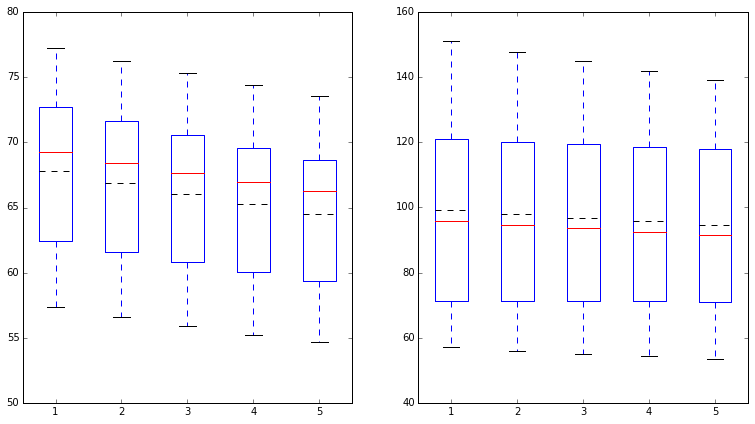

Training error: 60.9392772213
Testing error: 78.1358655876
N° iterations: 35248
Beta: [ 1.18251957 -0.13932677  3.77905972 -1.78536305 -0.03231867  2.56250732
  2.71625579  0.14680593  0.02130223 -0.13164147  2.2851568   0.68674787
  1.33404164]
###########################################################


###########################################################
Dataset: 3
Best alpha: 4.5e-07


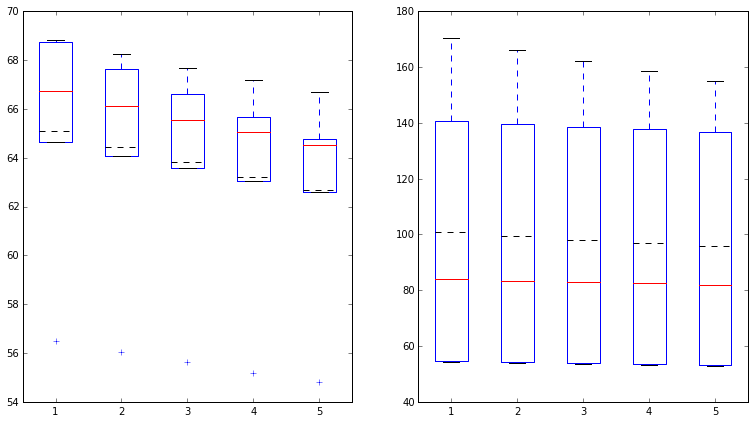

Training error: 58.9787768796
Testing error: 99.2667062665
N° iterations: 33095
Beta: [  1.25206878e+00  -1.89620806e-03   3.02982280e+00  -2.89611308e+00
  -4.39751522e-02   3.53022599e+00   2.54892401e+00  -3.29043001e-01
  -3.68449141e-03  -1.66866736e-01   1.88158381e+00   5.76212999e-01
   1.45492457e+00]
###########################################################


###########################################################
Dataset: 4
Best alpha: 4.5e-07


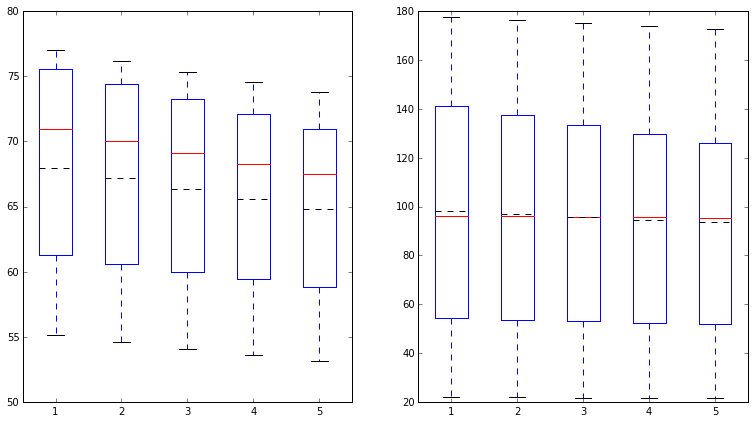

In [ ]:
solve_all(gd_online, params=params2)

### Gradient descent online for rescaled data [0,1]

In [ ]:
solve_all(gd_online, params=params1, data_func=rescale)

### Gradient descent online for normalized data

In [ ]:
solve_all(gd_online, params=params1, data_func=normalize)

### Newton-Raphson for raw data

In [ ]:
solve_all(nr_linear)

### Newton-Rhapson for rescaled data [0,1]

In [ ]:
solve_all(nr_linear, data_func=rescale)

### Newton-Raphson for normalized data

In [ ]:
solve_all(nr_linear, data_func=normalize)